In [1]:
import polars as pl
import pandas as pd
import numpy as np
import os
import shutil
import glob 

___
### Extracting Data
___

In [112]:
def simplify_folder_structure(base_path):
    # Get the path to the innermost folder
    last_folder = os.path.basename(os.path.normpath(base_path))
    parent_folder = "../data/raw/trade/"
    
    # Move the innermost folder to the parent of the root directory
    new_location = os.path.join(parent_folder, last_folder)
    
    # Ensure new location doesn't exist to avoid overwriting
    if os.path.exists(new_location):
        raise FileExistsError(f"Target folder {new_location} already exists!")
    
    shutil.move(base_path, new_location)
    
    # Remove the now-empty folder structure
    root_folder = os.path.dirname(parent_folder)
    while os.path.isdir(root_folder):
        try:
            os.rmdir(root_folder)  # Will remove empty directories only
            root_folder = os.path.dirname(root_folder)
        except OSError:
            break  # Stop if the directory is not empty
    
    print(f"Folder structure simplified to: {new_location}")


# Loop through all target folders
def process_all_folders(root_directory):
    # Find all candidate directories under `trade`
    for dirpath, dirnames, _ in os.walk(root_directory):
        if 'data ' in dirpath:
            if "trade" in dirpath:
                # Process each subfolder under 'trade' that has further folders
                for dirname in dirnames:
                    full_path = os.path.join(dirpath, dirname)
                    try:
                        simplify_folder_structure(full_path)
                    except Exception as e:
                        print(f"Failed to process {full_path}: {e}")

# Example usage
root_directory = "../data/raw/trade"  # Adjust to your root directory
#process_all_folders(root_directory)

In [2]:
dirData_raw = "../data/raw/"
dirData_clean = dirData_raw.replace("raw","clean")
if not os.path.isdir(dirData_clean):
    os.makedirs(dirData_clean)

tickers = os.listdir(dirData_raw)
tickers.remove('.DS_Store')
print(tickers)

['AHC', 'CNP', 'TFC', 'MHS', 'TEL', 'AAP', 'PLL', 'MBF', 'AGN', 'ADS', 'CAH', 'PCS', 'PFE', 'REG', 'TFX', 'ABD', 'BTM', 'MAR', 'ABC', 'SYK', 'LTD', 'MMC', 'TIF', 'FRT', 'PLD', 'MMM', 'PIR', 'EMN', 'AMT', 'ADI', 'MAA', 'IDX', 'DRE', 'MAS', 'UA', 'CNC', 'VLO', 'SPC', 'JWN', 'OKE', 'SYY', 'SNA', 'RTN', 'NU', 'UHS', 'HOC', 'GPN', 'DLR', 'BLL', 'NI', 'HP', 'SNT', 'LEE', 'BLK', 'MA', 'PRU', 'SHW', 'VTR', 'GPS', 'TXT', 'APD', 'FIS', 'ESV', 'UNP', 'NCB', 'WAB', 'RSG', 'IR', 'AWK', 'EXR', 'WCG', 'ITI', 'EW', 'LMT', 'CI', 'PPL', 'LNT', 'LB', 'BAC', 'CF', 'IT', 'SEE', 'DHI', 'MXB', 'FE', 'BBY', 'DNB', 'IRM', 'ITT', 'PVH', 'WLP', 'DGX', 'CRM', 'EQR', 'ED', 'BAX', 'DHR', 'WEC', 'ALB', 'MOS', 'WM', 'ICE', 'COG', 'RHI', 'AIZ', 'PHM', 'TGT', 'ALK', 'SWK', 'AFL', 'VAR', 'RMD', 'AJG', 'IFF', 'G', 'EFX', 'MET', 'TDG', 'MES', 'PNR', 'ACN', 'COH', 'COO', 'FPL', 'AEP', 'COF', 'LYV', 'VMC', 'HSY', 'TAP', 'NUE', 'ZMH', 'MCK', 'A', 'AIG', 'WY', 'O', 'STE', 'AEE', 'XEC', 'DRI', 'NRG', 'CMG', 'PEG', 'MKC', 'CMI'

___
### Column Format Check
___

In [4]:

def col_format_check(ticker):
    allfiles = glob.glob(dirData_raw+ticker+"/*parquet")

    all_dtypes = [pl.scan_parquet(myfile).collect_schema().dtypes() for myfile in allfiles]

    dtypes_DF = pd.DataFrame(all_dtypes)
    dtypes_DF = dtypes_DF.astype(str)

    most_common_data_types = pd.DataFrame(dtypes_DF.value_counts()).iloc[0].name

    for idx in range(len(all_dtypes)):
        my_dtypes=all_dtypes[idx]
        my_dtypes=[str(x) for x in my_dtypes]

        all_good = all([a==b for a,b in zip(my_dtypes,most_common_data_types)])
        if not all_good:
            os.rename(allfiles[idx],allfiles[idx]+"-bad")

for ticker in tickers:
    col_format_check(ticker)

___
### Wrangle/Load Functions
___

In [26]:
from arch import arch_model
from concurrent.futures import as_completed, ProcessPoolExecutor
from typing import Any, Dict, List, Optional, Tuple

def de_garch_returns(
    folder_name: str,
    asset_name: str,
    max_p: int=1,
    max_q: int=1,
    criterion: str='BIC',
    stop_n_rows=10**4,
    verbose: bool = False,
) -> Tuple[str, pd.Series]:
    """
    Fit a GARCH model for a single asset's returns, selecting the optimal (p, q) order.
    
    Args:
        asset_returns (pd.Series): Series of returns for a single asset.
        asset_name (str): Name of the asset.
        max_p (int): Maximum lag order for GARCH term.
        max_q (int): Maximum lag order for ARCH term.
        criterion (str): Information criterion for model selection ('AIC' or 'BIC').
        verbose (bool): Whether to print model fitting information.
    
    Returns:
        tuple: Asset name, best order (p, q), and standardized residuals (de-GARCHed returns).
    """

    # Load the asset returns
    asset = pl.read_parquet(f"../data/clean/{folder_name}/{asset_name}-trade.parquet").to_pandas()
    asset_returns = asset["log-return"]

    best_criterion = np.inf
    best_order = (1, 1)

    scaling = 10**4
    asset_returns = asset_returns * scaling # Scale returns for numerical stability
    
    # Grid search for best (p, q) order based on AIC or BIC
    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            try: 
                model = arch_model(asset_returns, vol='Garch', p=p, q=q)
                fit = model.fit(disp='off')
                model_criterion = fit.aic if criterion == 'AIC' else fit.bic
                
                if model_criterion < best_criterion:
                    best_criterion = model_criterion
                    best_order = (p, q)
            except Exception as e:
                print(f"Could not fit ({p}, {q}) for {asset_name}: {e}")

    # Fit the final model with the optimal order
    best_p, best_q = best_order
    final_model = arch_model(asset_returns, vol='Garch', p=best_p, q=best_q)
    final_fit = final_model.fit(disp='off')
    standardized_residuals = final_fit.resid / final_fit.conditional_volatility
    standardized_residuals = standardized_residuals / scaling  # Rescale residuals back to original units
    
    if verbose:
        print(f"Asset: {asset_name}, Best Order: ({best_p}, {best_q}), {criterion}: {best_criterion}")
    

    asset["log-return"] = standardized_residuals

    asset.to_parquet(f"../data/clean/{folder_name}/'deGARCH/{asset_name}-trade.parquet", engine='pyarrow')

    return


def de_garch_returns_parallel(
    returns: List[str],
    model_type: str = 'GARCH',
    max_p: int = 3,
    max_q: int = 3,
    criterion: str = 'BIC'
) -> pd.DataFrame:
    """
    Apply GARCH de-volatilization to a DataFrame of returns by selecting the optimal model 
    order based on an information criterion, using parallel processing.

    Args:
        returns (pd.DataFrame): DataFrame of asset returns.
        model_type (str): Type of GARCH model to use. Options are 'GARCH', 'EGARCH', or 'GJR-GARCH'.
        max_p (int): Maximum lag order for the GARCH term to consider.
        max_q (int): Maximum lag order for the ARCH term to consider.
        criterion (str): Information criterion for model selection ('AIC' or 'BIC').

    Returns:
        pd.DataFrame: DataFrame of de-GARCHed returns.
    """
    #de_garched_returns = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    with ProcessPoolExecutor(1) as executor:
        futures = {
            executor.submit(de_garch_returns, asset_name): asset_name
            for asset_name in returns
        }

        for future in as_completed(futures):
            asset_name, standardized_residuals = future.result()

    return 

In [43]:
def wrangle_trade_file(DF,
            tz_exchange="America/New_York",
            only_non_special_trades=True,
            only_regular_trading_hours=True,
            merge_sub_trades=True,
            round_to_seconds=False,):
    
    excel_base_date = pl.datetime(1899, 12, 30)  # Excel starts counting from 1900-01-01, but Polars needs 1899-12-30

    DF = DF.with_columns(
        (pl.col("xltime") * pl.duration(days=1) + excel_base_date).alias("index")
    )
    DF = DF.with_columns([pl.col("index").dt.convert_time_zone(tz_exchange),
                          pl.col("trade-price").cast(pl.Float32),
                          (pl.col("trade-price")/pl.col("trade-price").shift(1)).cast(pl.Float32).alias("return"),
                          ])   
    DF = DF.with_columns(pl.col("return").log().alias("log-return"))

    if round_to_seconds:
        DF = DF.with_columns(pl.col("index").dt.round("1s"))
    
    if only_non_special_trades:
        DF=DF.filter(pl.col("trade-stringflag")=="uncategorized")

    # Drop Unnecessary Columns
    DF = DF.drop(["xltime","trade-rawflag","trade-stringflag", "return"])

    if merge_sub_trades:   # average volume-weighted trade price here
        DF=DF.group_by('index',maintain_order=True).agg([#(pl.col('trade-price')*pl.col('trade-volume')).sum()/(pl.col('trade-volume').sum()).alias('trade-price'),
                                                         pl.col('log-return').sum().alias('log-return')])        

    return DF


def clean_trade_file(filename,
            tz_exchange="America/New_York",
            only_non_special_trades=True,
            only_regular_trading_hours=True,
            merge_sub_trades=True,):
    """
    Load and Wrangles raw trade files in filename. 
    If given multiple files, it will concatenate them.
    The wrangled data will be saved in a parquet file in the clean directory.
    """
    try:
        if filename.endswith("csv") or filename.endswith("csv.gz"):
            DF=pl.scan_csv(filename)
        elif filename.endswith("parquet"):    
            DF=pl.scan_parquet(filename)
        else:
            print("cannot load file "+filename+" : unknown format")
            return None
    except:
        print(filename+" cannot be loaded")
        return None

    DF = wrangle_trade_file(DF,
            tz_exchange=tz_exchange,
            only_non_special_trades=only_non_special_trades,
            only_regular_trading_hours=only_regular_trading_hours,
            merge_sub_trades=merge_sub_trades,)

    return DF

___
### Wrangle Data
___

In [44]:
folder = "normal/"

for ticker in tickers:
    df = clean_trade_file(dirData_raw+ticker+"/*parquet")

    df.collect(streaming=True).write_parquet(dirData_clean+folder+ticker+"-trade.parquet")

In [ ]:
for ticker in tickers:
    de_garch_returns("rounded_to_sec", ticker)

___
### Joining Data
___

In [9]:
# stop_n_rows = 10**4

folder = 'normal/'

spy = pl.read_parquet(dirData_clean + folder + tickers[0] + "-trade.parquet").with_columns(pl.col("log-return").alias(tickers[0])).drop("log-return")

for i, ticker in enumerate(tickers[1:]):
    file_path = dirData_clean + folder + ticker + "-trade.parquet"
    try:
        df = pl.read_parquet(file_path)
        df = df.rename({"log-return": ticker})
        
        spy = spy.join(df, on='index', how="inner", coalesce=True)

    except Exception as e:
        print(f"Error reading {file_path}: {e}")


# Write the result
try:
    spy.sort("index").write_parquet(dirData_clean + folder + "SPY-trade.parquet")
except Exception as e:
    print(f"Error during final write: {e}")

In [10]:
folder = 'rounded_to_sec/'

spy = pl.scan_parquet(dirData_clean + folder +  "SPY-trade.parquet")

# Print number of non-null values in each row
spy.collect(streaming=True).count()

index,AHC,VZ,AMR,CNP,RCL,CAT,TFC,MHS,PM,TEL,AAP,PLL,MBF,AGN,ADS,CAH,CBG,PCS,PFE,REG,TFX,ABD,BTM,MAR,ABC,SYK,LTD,MMC,TIF,PEP,FRT,PLD,MMM,PIR,EMN,AMT,…,KFT,ACL,LUV,PNW,RL,GIS,ECL,EOG,KIM,CLX,E,MCO,UTX,COP,JPM,K,DVN,PNC,WRB,AOS,L,RE,COL,NSC,AES,PKG,HUM,HST,NVR,STT,TI,CCI,AIV,STZ,GLW,PKI,VNO
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


___
### Covariance Matrix
___

In [24]:
# Forward fill missing values
spy = spy.sort("index").select(pl.all().forward_fill().backward_fill())
spy.collect(streaming=True).write_parquet("spy_cleaned.parquet")

In [ ]:
# Compute the correlation matrix
correlation = spy.collect(streaming=True).corr()
correlation.collect()

___
### Experiments
___

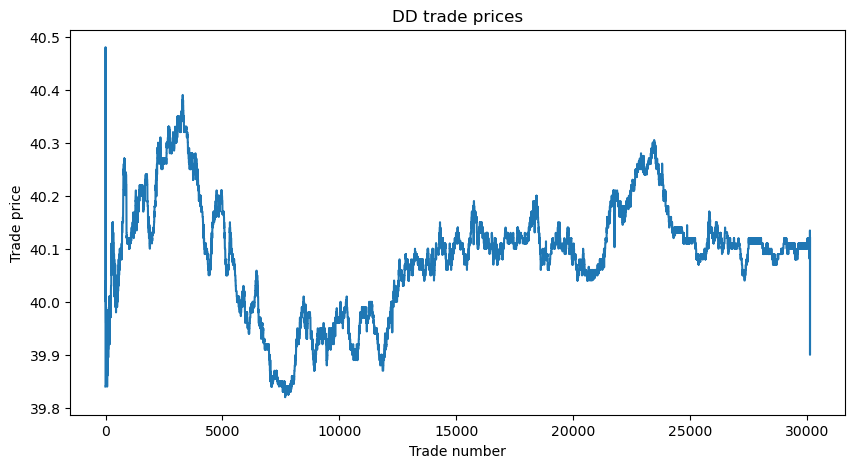

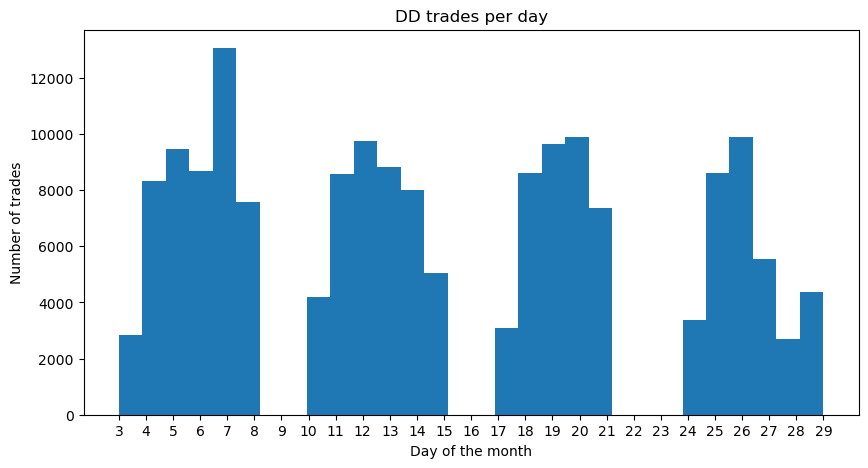

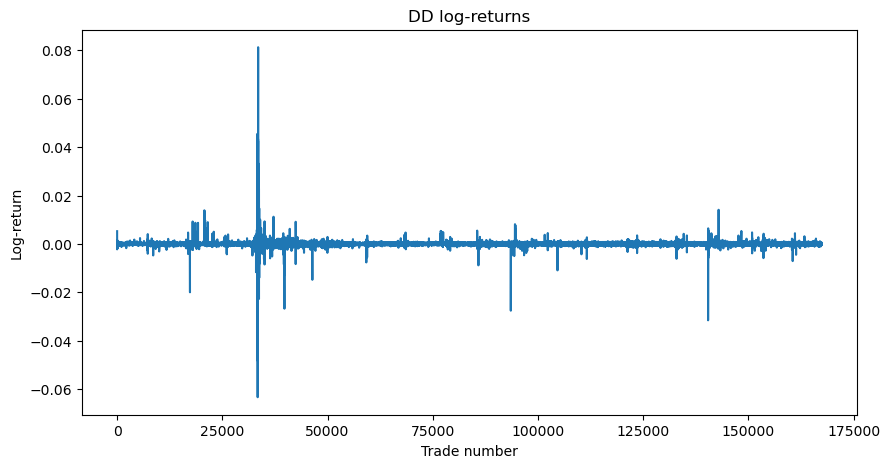

In [3]:
import polars as pl
import matplotlib.pyplot as plt

ticker = np.random.choice(tickers)

# Plot Asset Trade Prices
excel_base_date = pl.datetime(1899, 12, 30)  # Excel starts counting from 1900-01-01, but Polars needs 1899-12-30

asset_raw = pl.read_parquet(dirData_raw + ticker + f"/2010-05-03-{ticker}-trade.parquet")

asset_raw = asset_raw.with_columns(
    (pl.col("xltime") * pl.duration(days=1) + excel_base_date).alias("index")
)
asset_raw = asset_raw.with_columns([pl.col("index").dt.convert_time_zone("America/New_York"),
                        pl.col("trade-price").cast(pl.Float32),
                        (pl.col("trade-price")/pl.col("trade-price").shift(1)).cast(pl.Float32).alias("return"),
                        ])   
asset_raw = asset_raw.with_columns(pl.col("return").log().alias("log-return"))

trade_prices = asset_raw["trade-price"].to_numpy()
log_returns = asset_raw["log-return"].drop_nans().to_numpy()

plt.figure(figsize=(10, 5))
plt.plot(trade_prices)
plt.xlabel("Trade number")
plt.ylabel("Trade price")
plt.title(f"{ticker} trade prices")
plt.show()

# Plot Asset Trade Volume and Log-Returns
asset_clean = pl.read_parquet(dirData_clean+"normal/"+ ticker +"-trade.parquet")
asset_clean = asset_clean.with_columns([pl.col("index").dt.round("1d").alias("day"),
                            pl.col("index").dt.round("1h").alias("hour")])

returns = asset_clean["log-return"].to_numpy()
timestamps = asset_clean["index"].to_numpy()
days = asset_clean["day"].to_pandas().apply(lambda x: x.day)
hours = asset_clean["hour"].to_pandas().apply(lambda x: x.hour)

plt.figure(figsize=(10, 5))
plt.hist(days, bins=30)
plt.xticks(range(3, 30))
plt.xlabel("Day of the month")
plt.ylabel("Number of trades")
plt.title(f"{ticker} trades per day")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(returns)
plt.xlabel("Trade number")
plt.ylabel("Log-return")
plt.title(f"{ticker} log-returns")
plt.show()


**Upsampling**

In [72]:
# Find asset with the most trades
most_trades = None
folder = 'normal/'

for ticker in tickers:
    asset_clean = pl.read_parquet(dirData_clean + folder + ticker + "-trade.parquet").filter(pl.col("index").dt.day()==3)
    n_trades = len(asset_clean)
    if most_trades is None or n_trades > most_trades[1]:
        most_trades = (ticker, n_trades)
    
print(f"Asset with the most trades: {most_trades[0]} ({most_trades[1]} trades)")

Asset with the most trades: C (19060 trades)


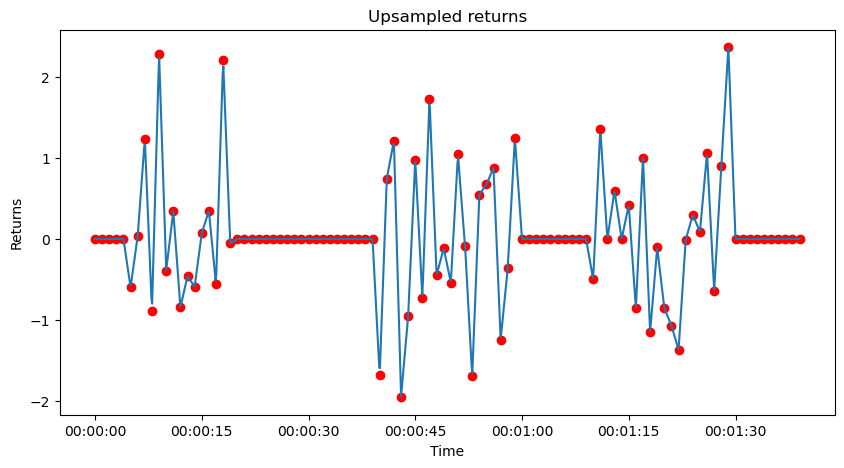

In [62]:
# Upsample all assets to the same number of samples

# def upsample(returns, timestamps, N_samples):
#     # Linearly interpolate the returns to upsample to N_samples
#     new_timestamps = pd.date_range(timestamps[0], timestamps[-1], N_samples).values

#     # Convert datetime64 to float for interpolation
#     timestamps = np.array([t.astype(int) for t in timestamps])
#     new_timestamps = np.array([t.astype(int) for t in new_timestamps])

#     new_returns = np.interp(new_timestamps, timestamps, returns)

#     # Convert back to datetime64
#     new_timestamps = pd.to_datetime(new_timestamps).values
#     new_timestamps = np.array([t.astype('datetime64[ns]') for t in new_timestamps])

#     return new_returns, new_timestamps

def upsample(returns, timestamps, N_samples):
    """
    Upsamples the given time series to `N_samples` using linear interpolation.

    Parameters:
    - returns (pd.Series): A pandas Series representing the log-return values.
    - timestamps (pd.Series): A pandas Series of datetime objects representing the index.
    - N_samples (int): The number of samples to upsample to.

    Returns:
    - pd.DataFrame: A DataFrame with upsampled timestamps and interpolated returns.
    """
    # Convert timestamps to numeric values for interpolation
    numeric_timestamps = timestamps.astype('int64')  # Nanoseconds since epoch
    
    # Generate an evenly spaced grid of N_samples timestamps
    min_time = numeric_timestamps.min()
    max_time = numeric_timestamps.max()
    new_timestamps = np.linspace(min_time, max_time, N_samples)
    
    # Interpolate returns on the new timestamp grid
    interpolated_returns = np.interp(new_timestamps, numeric_timestamps, returns)
    
    # Convert numeric timestamps back to datetime
    new_datetime_index = pd.to_datetime(new_timestamps, unit='ns')
    
    # Create a new DataFrame with upsampled data
    upsampled_df = pd.DataFrame({
        'timestamp': new_datetime_index,
        'log-return': interpolated_returns
    })
    return upsampled_df

# Test the upsample function
N_samples = 1000

timestamps = pd.date_range("2021-01-01", periods=100, freq="s").values
timestamps = np.array([t.astype('datetime64[ns]') for t in timestamps])

returns = np.zeros_like(timestamps, dtype=float)
returns[5:20] = np.random.randn(15)
returns[40:60] = np.random.randn(20)
returns[70:90] = np.random.randn(20)

upsampled_returns = upsample(returns, timestamps, N_samples)

new_returns = upsampled_returns["log-return"]
new_timestamps = upsampled_returns["timestamp"]

plt.figure(figsize=(10, 5))
plt.plot(new_timestamps, new_returns)
plt.scatter(timestamps, returns, color='red', label="Original returns")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Upsampled returns")
plt.show()

2482 2482


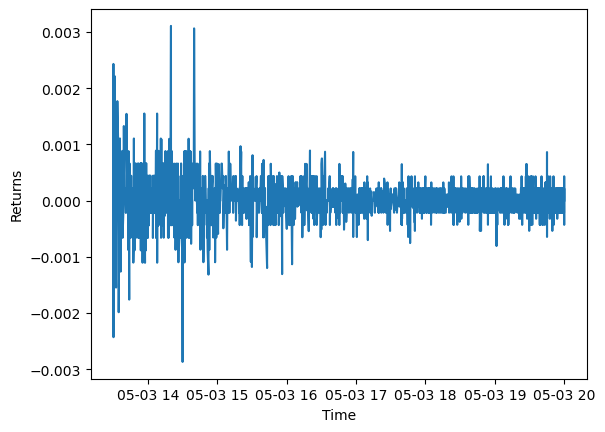

19060 19060


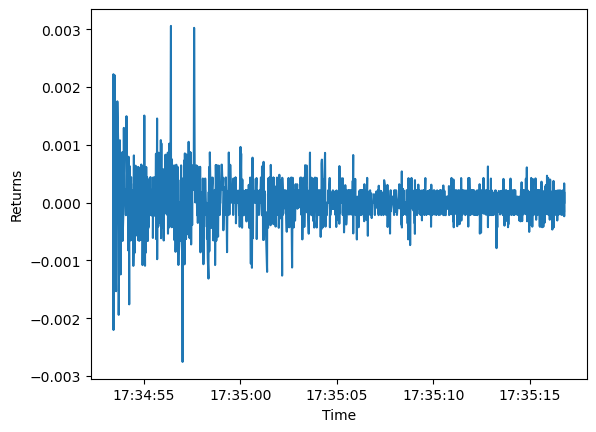

In [76]:
asset_most_trades = most_trades[0]
N_samples = most_trades[1]

folder = 'upsampled/'

for ticker in ['AAP']:
    asset_clean = pl.read_parquet(dirData_clean + 'normal/' + ticker + "-trade.parquet").filter(pl.col("index").dt.day()==3)
    returns = asset_clean["log-return"].to_numpy().astype(np.float64)
    timestamps = asset_clean["index"].to_numpy()

    print(len(returns), len(timestamps))
    
    plt.plot(timestamps, returns)
    plt.xlabel("Time")
    plt.ylabel("Returns")
    plt.show()

    upsampled_returns = upsample(returns, timestamps, N_samples)

    new_returns = upsampled_returns["log-return"]
    new_timestamps = upsampled_returns["timestamp"]

    print(len(new_returns), len(new_timestamps))

    plt.plot(new_timestamps, new_returns)
    plt.xlabel("Time")
    plt.ylabel("Returns")
    plt.show()
    
    asset_clean = pl.DataFrame({"index": new_timestamps, "log-return": new_returns})
    asset_clean.write_parquet(dirData_clean + folder + ticker + "-trade.parquet")

In [8]:
asset = pd.read_parquet('/Users/Samuel/Documents/EPFL/Q1/Financial Big Data/FinancialBigData-Project/data/clean/normal/AAP-trade.parquet')
asset.head()

,index,log-return
0,2010-05-03 09:30:01-04:00,0.000665
1,2010-05-03 09:30:04-04:00,-0.002209
2,2010-05-03 09:30:06-04:00,0.002430
3,2010-05-03 09:30:10-04:00,-0.002430
4,2010-05-03 09:30:18-04:00,-0.000221
